In [4]:
import os
import sys
sys.path.append('/home/alexli/git/JupiterScripts/apps/embedded_metrics')

%matplotlib inline
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from metrics.generic_metrics import get_runs, get_window_df, get_recall_at_dust
from metrics.embedded_product_metrics_config import EmbeddedProductMetricsConfig as config

In [5]:
COMPUTE_DUST_THRESHOLD = (os.environ['COMPUTE_DUST_THRESHOLD'].lower() == 'true') if 'COMPUTE_DUST_THRESHOLD' in os.environ else False
RUN_LEVEL_ANALYSIS = (os.environ['RUN_LEVEL_ANALYSIS'].lower() == 'true') if 'RUN_LEVEL_ANALYSIS' in os.environ else False
if 'EMBEDDED_RESULTS_DIR' in os.environ:
    EMBEDDED_RESULTS_DIR = os.environ['EMBEDDED_RESULTS_DIR']
else:
    EMBEDDED_RESULTS_DIR = '/metrics'

In [26]:
my_path = '/home/alexli/logs/summary_1_2_5.csv'
if os.path.exists(my_path):
    df = pd.read_csv(my_path)
    RUN_LEVEL_ANALYSIS = True
    COMPUTE_DUST_THRESHOLD = True
    df_orig = df.copy()
# The original dust dataset. To ensure that the data does not drift too much in difficulty, we want the average the dust level across runs to be close to the average dust level of this dataset
runs = get_runs(df)
runs = [r for r in runs if np.mean(r['dust_percent']) > 0 and len(r) > 2]
good_dust_distribution_data = pd.concat([r for r in runs if (('2023-03-29' < r.iloc[0]['collected_on'])  & (r.iloc[0]['collected_on'] < '2023-04-06'))])
if len(good_dust_distribution_data):
    all_dust_distribution_data = pd.concat(runs)
    # We would like to have an average dust level 'close' to this, let's define it as being in the interval [min_required_dust_percent, max_required_dust_percent]
    min_required_dust_percent = min(np.percentile(good_dust_distribution_data['dust_percent'], 40), np.mean(good_dust_distribution_data['dust_percent']) * .95)
    max_required_dust_percent = max(np.percentile(good_dust_distribution_data['dust_percent'], 60), np.mean(good_dust_distribution_data['dust_percent']) * 1.05)
    print(min_required_dust_percent)
    print(max_required_dust_percent) # We don't enforce max ATP

    # np.percentile(good_dust_distribution_data['dust_percent'], 30)
    runs_sorted = sorted(runs, key=lambda r: np.mean(r['dust_percent']))
    all_dust_distribution_data = pd.concat(runs_sorted)
    while np.mean(all_dust_distribution_data['dust_percent']) <= min_required_dust_percent:
        all_dust_distribution_data = pd.concat(runs_sorted)
        droppable_runs = np.sum(np.array([[np.mean(r['dust_percent']) < min_required_dust_percent] for r in runs_sorted]))
        to_drop_ind = int(np.random.triangular(0, 0, droppable_runs - 1e-6))
        runs_sorted.pop(to_drop_ind)
    ok_images = pd.concat(runs_sorted)
    print(np.mean(ok_images['dust_percent']))
df = df[df['id'].isin(ok_images['id'])]
print("Updated DF")

17.66749382019043
23.8559513092041
18.331187490763178
Updated DF


In [27]:
from aletheia_dataset_creator.dataset_tools.aletheia_dataset_helpers import imageids_to_dataset
imageids_to_dataset(df['id'], dataset_name=f'vehicles_driving_through_dust_1_2_5_hard ({len(df["id"])} images)',
                    dataset_description="Vehicles driving through dust behind the tractor",
                    dataset_kind='annotation', production_dataset=False)

INFO:botocore.tokens:Loading cached SSO token for brt


INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Preparing stereo dataframe...
Size of left dataframe: 2861
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading cached SSO token for brt
INFO:botocore.tokens:Loading

Size of stereo dataframe: 2861
Sending 2861 annotated_ids for creating dataset
Time taken to prepare data for dataset creation job: 1.06 mins


Based on the overall metrics, the recommended dust threshold is 0


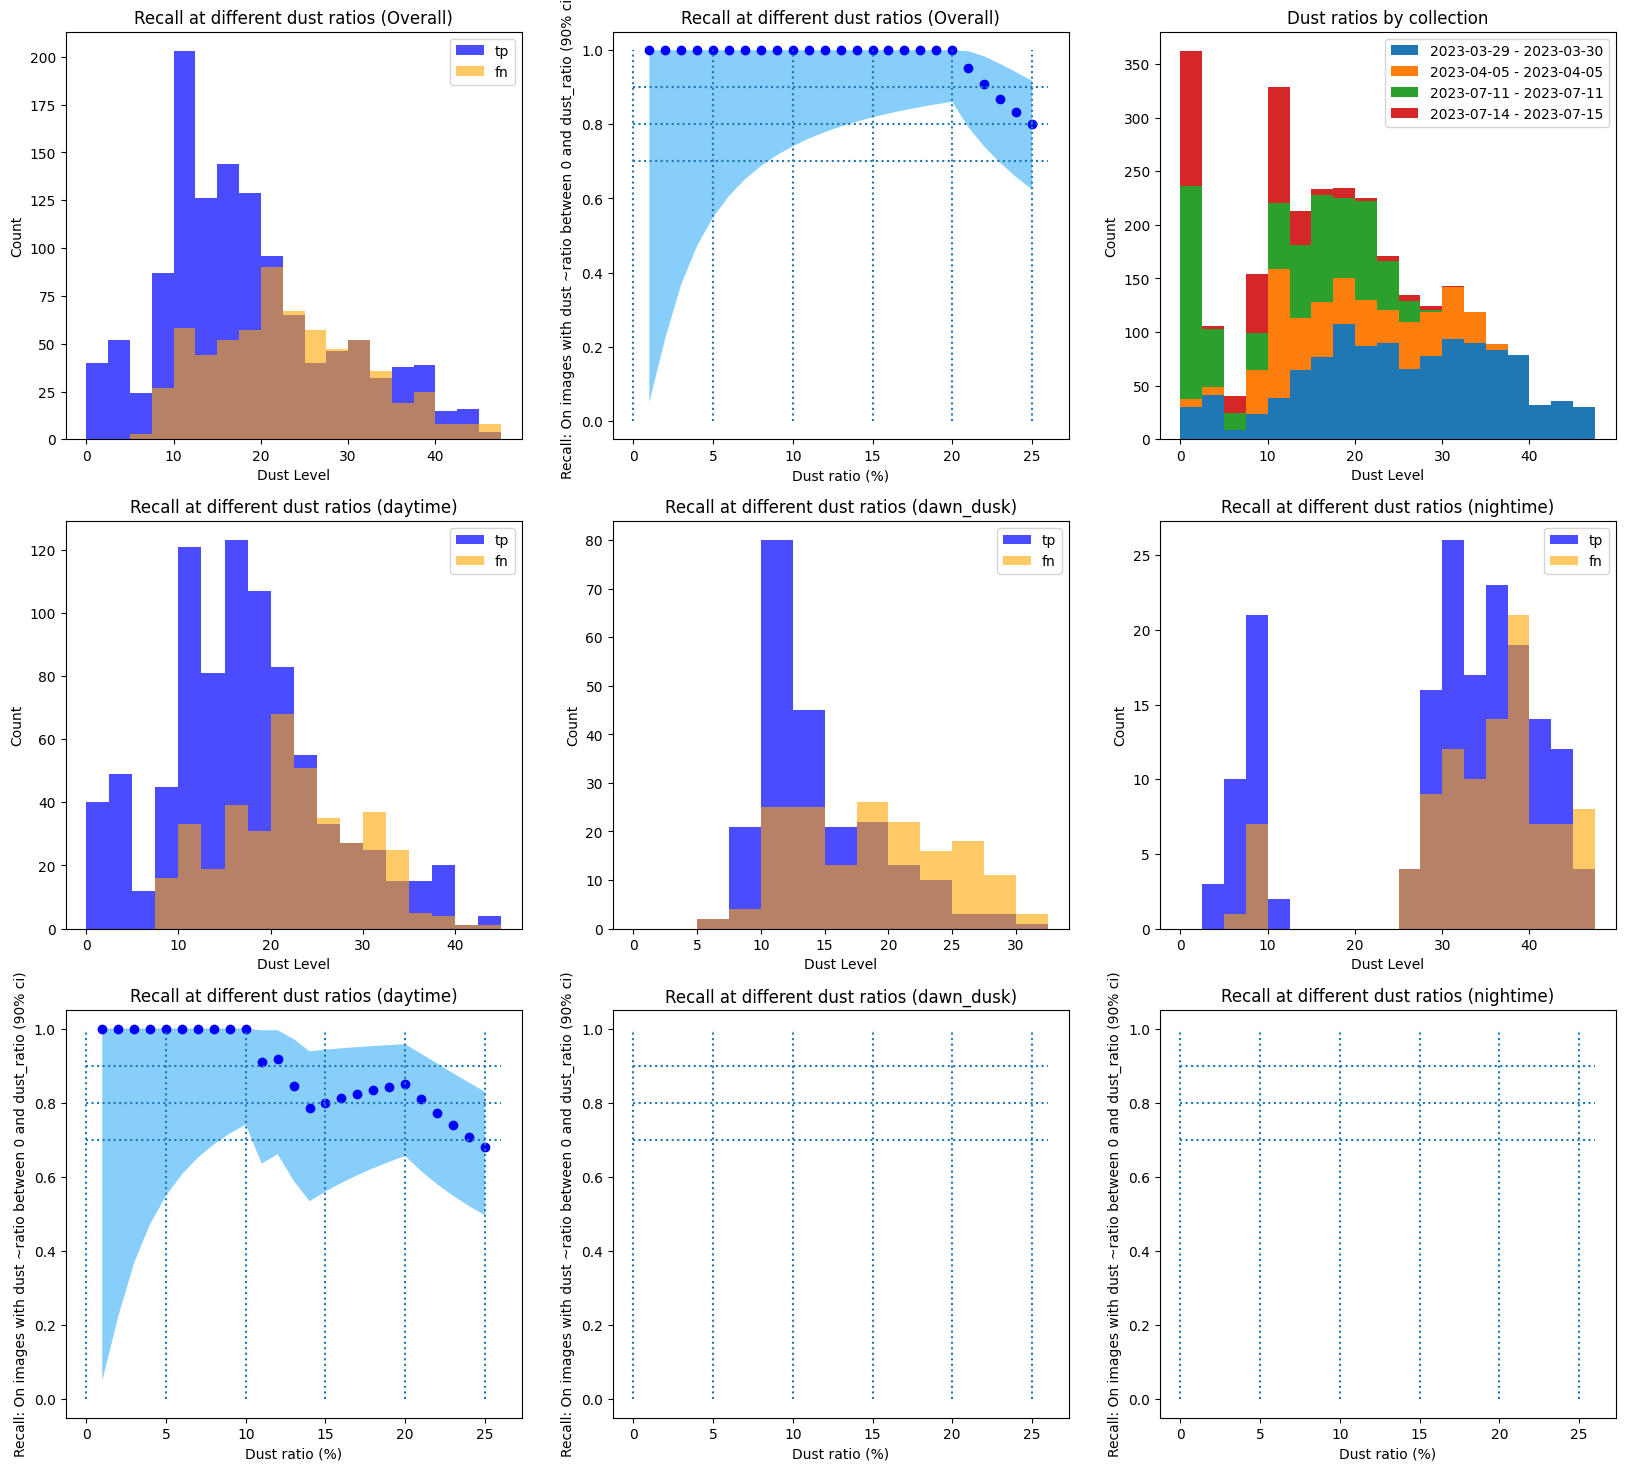

In [31]:
if COMPUTE_DUST_THRESHOLD:
    if max(df['dust_percent']) == 0:
        print("Possible error in publishing dust percent, all values are 0")
    # plt.show()
    def plot_recall_at_dust_hist(df, ax, subset):
        bins = np.arange(0, np.max(df['dust_percent']) + .01, 2.5)
        ax.hist(df[df[config.PREDICTED_ANY_STOP_CLASS] & df[config.LABEL_ANY_STOP_CLASS]]['dust_percent'], bins=bins, alpha=.7, label='tp', color='blue')
        ax.hist(df[(~df[config.PREDICTED_ANY_STOP_CLASS]) & df[config.LABEL_ANY_STOP_CLASS]]['dust_percent'], bins=bins, alpha=.6, label='fn', color='orange')
        ax.set_title(f"Recall at different dust ratios ({subset})")
        ax.set_xlabel("Dust Level")
        ax.set_ylabel("Count")
        ax.legend()
    def plot_recall_at_dust_threshold(df, ax, subset):
        at_dust = get_recall_at_dust(df)
        if subset == 'Overall':
            print(f"Based on the overall metrics, the recommended dust threshold is {at_dust['recommended_thresh']}")
        ax.fill_between(at_dust['dust_ratio'], [p['low'] for p in at_dust['tp_rate']], [p['high'] for p in at_dust['tp_rate']], facecolor='lightskyblue')
        ax.hlines([.7, .8, .9], 0, 26, linestyles='dotted')
        ax.vlines([0, 5, 10, 15, 20, 25], 0, 1, linestyles='dotted')
        ax.scatter(at_dust['dust_ratio'], [p['val'] for p in at_dust['tp_rate']], color='b')
        ax.set_title(f"Recall at different dust ratios ({subset})")
        ax.set_xlabel("Dust ratio (%)")
        ax.set_ylabel("Recall: On images with dust ~ratio between 0 and dust_ratio (90% ci)")

    fig, axs = plt.subplots(3, 3, squeeze=False, figsize=(20, 18))
    plot_recall_at_dust_hist(df, axs[0][0], 'Overall')
    plot_recall_at_dust_threshold(df, axs[0][1], 'Overall')
    plot_recall_at_dust_by_collection(df, axs[0][2])
    times = ['daytime', 'dawn_dusk', 'nightime']
    for i in range(len(times)):
        plot_recall_at_dust_hist(df[df['operation_time'] == times[i]], axs[1][i], times[i])
        plot_recall_at_dust_threshold(df[df['operation_time'] == times[i]], axs[2][i], times[i])
    fig.show()

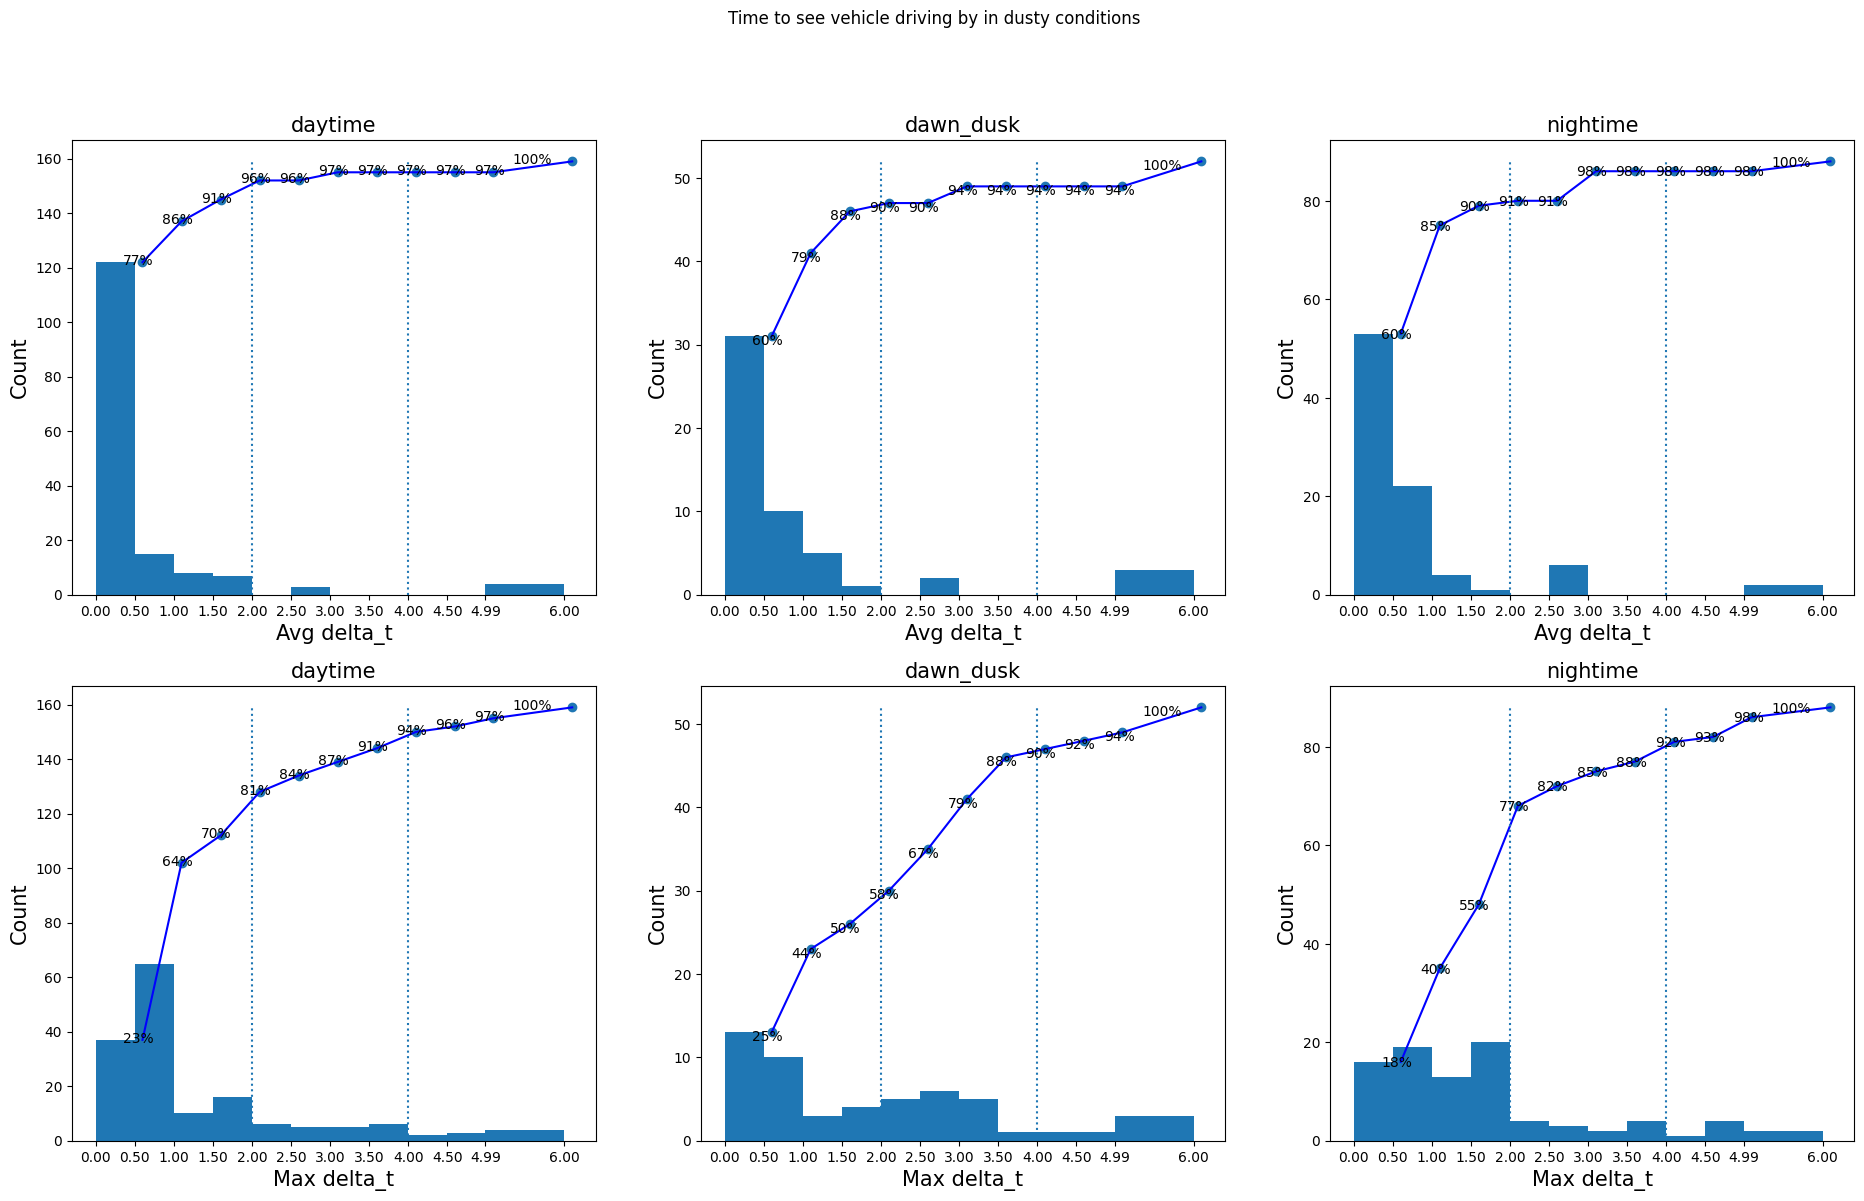

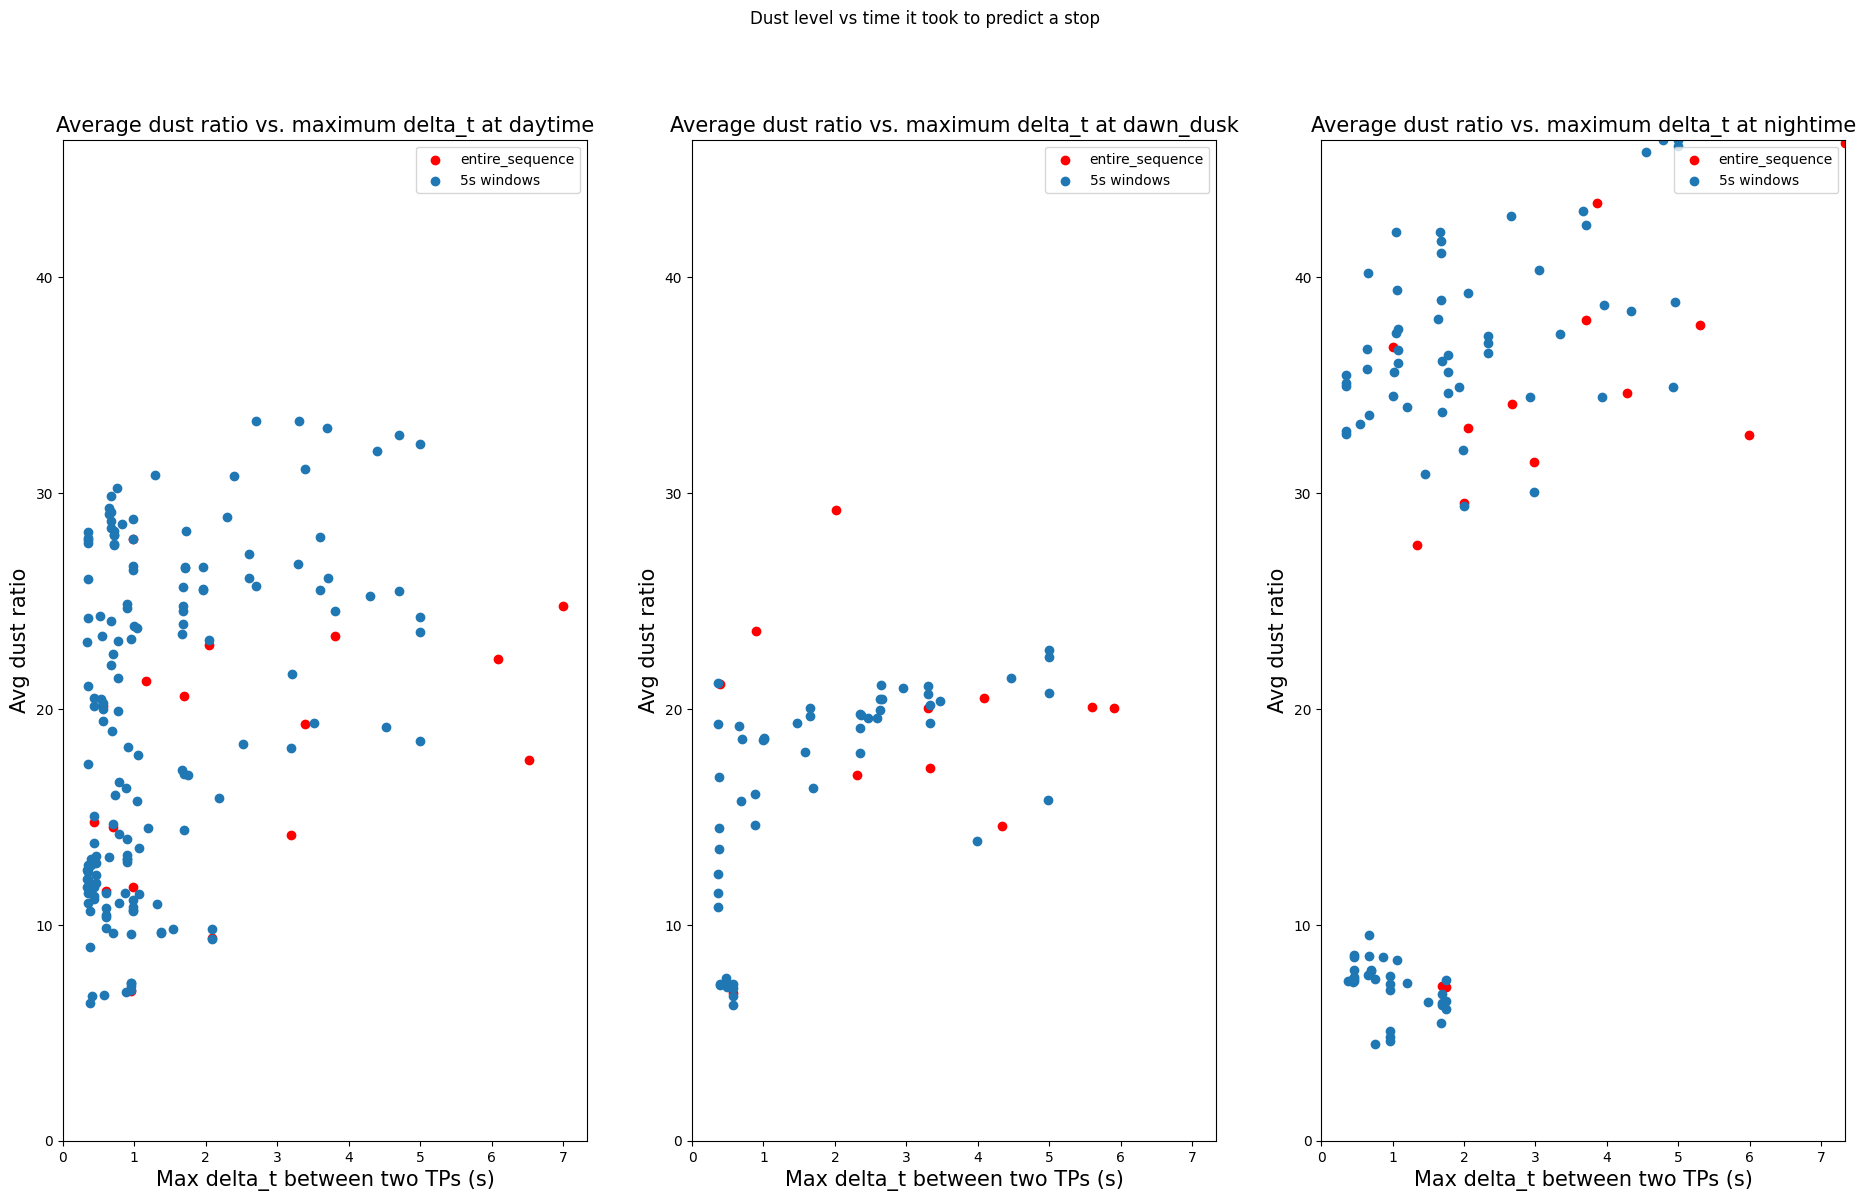

In [16]:
def plot_histogram_and_cumulative(points, title, xlabel, ax):
    # plt.figure(1, figsize=(8, 4))
    bins = [0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,4.99, 6]
    ax.hist(points, bins=bins)
    values, base = np.histogram(points, bins=bins)
    #evaluate the cumulative
    cumulative = np.cumsum(values)
    cum_x = [x + .1 for x in bins[1:]]
    # plot the cumulative function
    ax.plot(cum_x, cumulative, c='blue')
    ax.scatter(cum_x, cumulative)
    for b,c in zip(base[:-1], cumulative):
        ax.annotate(f'{c/cumulative[-1]*100:.0f}%', (b+0.35,c-1))
    ax.set_title(title, fontsize=15)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel('Count', fontsize=15)
    ax.set_xticks(bins) 
    ylim = cumulative[-1]
    ax.set_ylim([0, ylim * 1.05])
    ax.vlines([2, 4], 0, ylim, linestyles='dotted')

if RUN_LEVEL_ANALYSIS:
    runs = get_runs(df)
    
    all_windows = [get_window_df(run, 5) for run in runs]
    sliding_window_df = pd.concat(all_windows)
    all_windows_full = [get_window_df(run, window_size_seconds='full') for run in runs]
    all_windows_full = [w for w in all_windows_full if len(w) > 0]
    full_run_df = pd.concat(all_windows_full)

    # Plot histograms with cumulative distribution of detections as time passes
    fig, axarr = plt.subplots(2, 3, figsize=(23, 13))
    fig.suptitle("Time to see vehicle driving by in dusty conditions")
    for ind, op_time in enumerate(['daytime', 'dawn_dusk', 'nightime']):
        window = sliding_window_df[sliding_window_df['operation_time'] == op_time]
        if not len(window):
            continue
        title = f'{op_time}'
        xlabel = 'Avg delta_t'
        plot_histogram_and_cumulative(window['avg_delta_t'], title, xlabel, axarr[0][ind])

        title = f'{op_time}'
        xlabel = 'Max delta_t'
        plot_histogram_and_cumulative(window['max_delta_t'], title, xlabel, axarr[1][ind])
    fig.show()

    # Plot scatter with dust level vs time to get a detection
    fig, axarr = plt.subplots(1, 3, figsize=(23, 13))
    fig.suptitle("Dust level vs time it took to predict a stop")

    xlim = max(5, max(full_run_df['max_delta_t']))
    ylim = max(max(full_run_df['avg_dust_level']), max(sliding_window_df['avg_dust_level']))
    for ind, op_time in enumerate(['daytime', 'dawn_dusk', 'nightime']):
        ax = axarr[ind]
        window_5s = sliding_window_df[sliding_window_df['operation_time'] == op_time]
        window_full = full_run_df[full_run_df['operation_time'] == op_time]
        if not len(window_full):
            continue
        ax.scatter(window_full['max_delta_t'], window_full['avg_dust_level'], c='red', label='entire_sequence')
        ax.scatter(window_5s['max_delta_t'], window_5s['avg_dust_level'], label='5s windows')
        ax.set_title(f'Average dust ratio vs. maximum delta_t at {op_time}', fontsize=15)
        ax.set_xlabel(f'Max delta_t between two TPs (s)', fontsize=15)
        ax.set_ylabel('Avg dust ratio', fontsize=15)
        ax.set_xlim([0, xlim])
        ax.set_ylim([0, ylim])
        ax.legend()
    fig.show()

Plot sequence detections for runs with a period of no detections 3s or more longer than ground truth.
False negatives for run starting at 2023-03-29 22:29:30
6425b3f988ab036228b77db7,6425b3b188ab036228b77ce7,6425b3b3fb0cfb5575a9ebe3,6425b3bf88ab036228b77d17,6425b3c088ab036228b77d1a,6425b32287f5eb64dd52be49,6425b34187f5eb64dd52bef6,6425b34287f5eb64dd52bef9,6425b36088ab036228b77bbb,6425b36188ab036228b77bc5,6425b32998afdc9829568946,6425b32a87f5eb64dd52be85,6425b41088ab036228b77e13,6425b40fafb870a21b523852,6425b3ab87f5eb64dd52c102,6425b37788ab036228b77c26,6425b37888ab036228b77c32,6425b3e788ab036228b77d8d,6425b39efb0cfb5575a9ebc0,6425b3fb88ab036228b77dba,6425b3fcfb0cfb5575a9ec96,6425b335fb0cfb5575a9e7b7,6425b334afb870a21b5236bc,6425b30787f5eb64dd52bdd1,6425b348fb0cfb5575a9e88d,6425b31b88ab036228b77a5b,6425b2fecd93dce1db95e9e2,6425b380fb0cfb5575a9eae5,6425b35dfb0cfb5575a9e985,6425b35e98afdc9829568a0b,6425b40288ab036228b77ddc,6425b3dd87f5eb64dd52c127,6425b397fb0cfb5575a9eb9e,6425b2edfb0cfb557

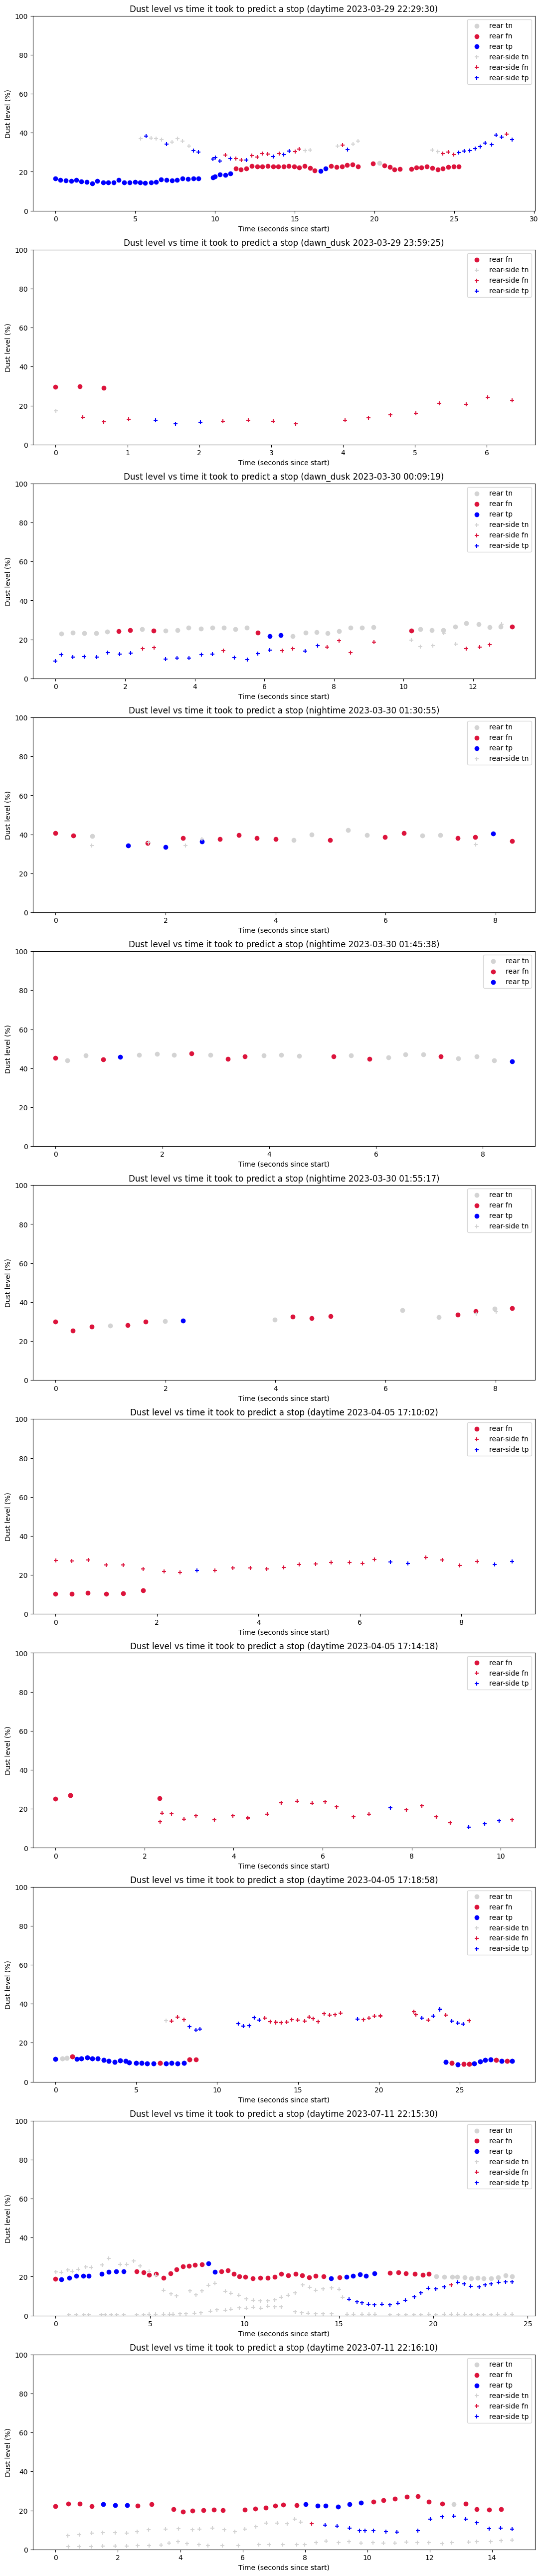

In [11]:
def plot_one_run(run: pd.DataFrame, ax, ind) -> None:
    """Plot the detections for one sequence of video images

    Args:
        run: A df with at least the columns
            - camera_location, predicted_stop, label_stop, dust_percent (same meaning as elsewhere)
            and 
            - collected_on_dt: The datetime that this run was collected, to be plotted on the x axis
    """
    start_t = run.iloc[0]['collected_on_dt']
    ax.set_title(f"Dust level vs time it took to predict a stop ({run.iloc[0]['operation_time']} {ind})")

    def seconds_since_start(datetime):
        return float((datetime - start_t).total_seconds())

    for cam_desc, cam_array in zip(('rear', 'rear-side'), (['rear-left', 'rear-right'], ['side-left-left', 'side-right-left', 'side-left-right', 'side-right-right'])):
        for label_stop, predicted_stop, error_type in (
            (False, False, 'tn'),
            (True, False, 'fn'),
            (False, True, 'fp'),
            (True, True, 'tp')):
            run_subset = run.loc[run['camera_location'].isin(cam_array) & (run[config.PREDICTED_ANY_STOP_CLASS] == predicted_stop) & (run[config.LABEL_ANY_STOP_CLASS] == label_stop)]
            # Really hard to choose a color scheme because green/red=stop and also green/red=right/wrong.
            # If you try to mix the marker I think it's even more confusing, so just use that to indicate camera
            marker = 'o' if cam_desc == 'rear' else '+'

            if label_stop: # Darker colors
                if predicted_stop:
                    color = 'blue'
                else:
                    color = 'crimson' # Color of blood because u crash
            else: # lighter colors as they are less important
                if predicted_stop:
                    color = 'papayawhip'
                else:
                    color = 'lightgray'
            x = run_subset['collected_on_dt'].apply(seconds_since_start)
            if len(x):
                ax.scatter(x, run_subset['dust_percent'], label=f'{cam_desc} {error_type}', color=color, marker=marker)
    ax.legend()
    ax.set_xlabel("Time (seconds since start)")
    ax.set_ylabel("Dust level (%)")
    ax.set_ylim([0, 100])

if RUN_LEVEL_ANALYSIS:
    to_plot = []
    for i in range(len(all_windows_full)):
        window = all_windows_full[i].iloc[0]
        if window['max_delta_t'] - window['max_delta_t_gt'] >= 3:
            to_plot.append((runs[i].iloc[0]['collected_on_dt'].strftime('%Y-%m-%d %H:%M:%S'), runs[i]))
    if len(to_plot):
        print("Plot sequence detections for runs with a period of no detections 3s or more longer than ground truth.")
        fig, axarr = plt.subplots(len(to_plot), figsize=(13, 6 * len(to_plot)), squeeze=False)
        for i, (ind, run) in enumerate(to_plot):
            axarr[i][0].clear()
            plot_one_run(run, axarr[i][0], ind)
            run_fns = run[(~run[config.PREDICTED_ANY_STOP_CLASS]) & run[config.LABEL_ANY_STOP_CLASS]]
            print(f"False negatives for run starting at {ind}")
            print(",".join(list(run_fns['id'])))
        print("You can view all failed images at https://www.aletheiav2.prod.mesa.brtws.com/images?project_name=jupiter")
        fig.show()